In [131]:
import numpy as np
import scipy
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from typing import Callable, Union, Iterable

import torch
from torch import nn
import torch.distributions as dist

import gpytorch
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import VariationalStrategy
from gpytorch.utils.cholesky import psd_safe_cholesky

from data.get_data import get_data

In [132]:
%config InlineBackend.figure_format = "retina"
sns.set()

In [133]:
def inv_softplus(x):
    return torch.log(torch.exp(x) - 1)

In [134]:
np.random.seed(123)

In [135]:
def m(x, theta):
    delta, rep = x.T
    alpha, beta = theta
    return np.exp(-alpha*(1-beta)**rep*delta)

In [136]:
class Model(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.unc_alpha = nn.Parameter(torch.zeros(1))
        self.unc_beta = nn.Parameter(torch.zeros(1))
    
    def forward(self, x):
        
        delta, rep = x.T
        
        alpha = nn.functional.softplus(self.unc_alpha)
        beta = torch.sigmoid(self.unc_beta)
        
        log_p = -alpha*(1-beta)**rep*delta
        p = log_p.exp()
        return p

In [137]:
delta = np.random.uniform(0, 2**5, 1000)
rep = np.random.randint(0, 10, size=1000)

x = np.concatenate((df.d.values[None, :], df.r.values[None, :]), axis=0).T
y = (m(x, (0.05, 0.2)) > np.random.random(x.shape[0])).astype(int)

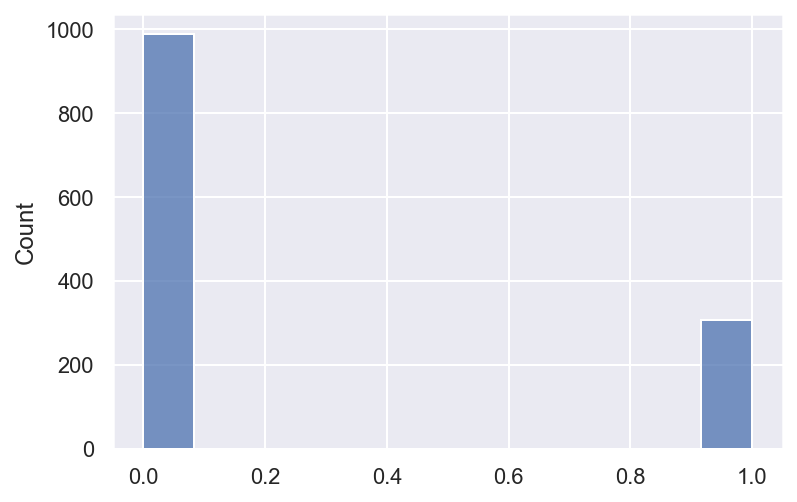

In [138]:
sns.histplot(y);

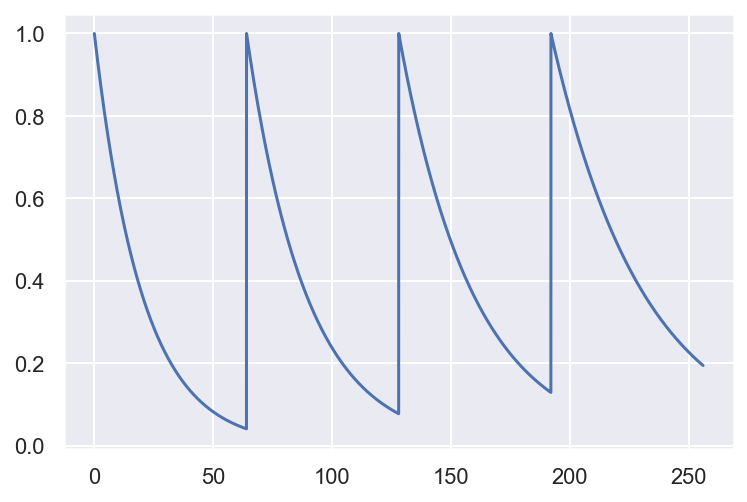

In [139]:
x_plot = np.linspace(0, 2**8, 8000)

presentations = np.arange(2000, 8000, 2000)

delta = x_plot.copy()
rep = np.zeros(x_plot.shape)

for pres in presentations:

    delta[pres:] = x_plot[pres:] - x_plot[pres]
    rep[pres:] += 1

x_input = np.concatenate((delta[None, :], rep[None, :]), axis=0).T

y_plot = m(x_input, (0.05, 0.2))
plt.plot(x_plot, y_plot);

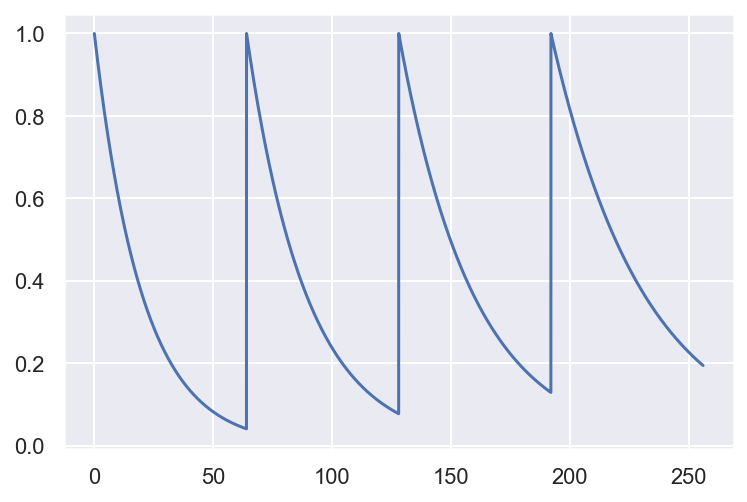

In [140]:
with torch.no_grad():
    ref_model = Model()
    ref_model.unc_alpha[0] = inv_softplus(torch.tensor([0.05]))
    ref_model.unc_beta[0] = scipy.special.logit(0.2)
    
    y_plot_model = ref_model(torch.from_numpy(x_input)).numpy()

plt.plot(x_plot, y_plot_model);

In [141]:
def obj(theta):
    p_suc = m(x, theta)
    p = p_suc**y*(1-p_suc)**(1-y)
    logp = np.log(p+1e-07)
    return - logp.sum()

scipy.optimize.minimize(obj, x0=(0, 0.5), bounds=((0, np.inf), (0, 1)))

      fun: 92.18860726204862
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-8.52651283e-05,  4.12114787e-05])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 156
      nit: 36
     njev: 52
   status: 0
  success: True
        x: array([0.04310014, 0.18459203])

In [142]:
def fit_data(x, y, learning_rate=0.01, epochs=1000):
    
    train_x = torch.from_numpy(x.astype(np.float32))
    train_y = torch.from_numpy(y.astype(np.float32))
    
    model = Model()


    # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=learning_rate)

    hist_loss = []

    pbar = tqdm(total=epochs)

    for i in range(epochs):
        # Zero backpropped gradients from previous iteration
        optimizer.zero_grad()
        # Get predictive output
        p = model(train_x)

        # Calc loss and backprop gradients
        # p = p_suc**train_y*(1-p_suc)**(1-train_y)
        logp = dist.Bernoulli(probs=p).log_prob(train_y)
        loss = -logp.sum()
        loss.backward()

        optimizer.step()

        hist_loss.append(loss.item())

        if pbar is not None:
            pbar.set_postfix(loss=loss.item())
            pbar.update()

    if pbar is not None:
        pbar.close()
        
    opt = {k: torch.tensor([v]) for k, v in model.named_parameters()}
    alpha = nn.functional.softplus(opt["unc_alpha"]).item()
    beta = torch.sigmoid(opt["unc_beta"]).item()
    
    print(opt)
    print("alpha", alpha)
    print("beta", beta)
    
    return hist_loss, (alpha, beta)

In [143]:
hist_loss, (alpha, beta) = fit_data(x, y)

  0%|          | 0/1000 [00:00<?, ?it/s]

{'unc_alpha': tensor([-2.9279]), 'unc_beta': tensor([-1.3939])}
alpha 0.05212530121207237
beta 0.1987798810005188


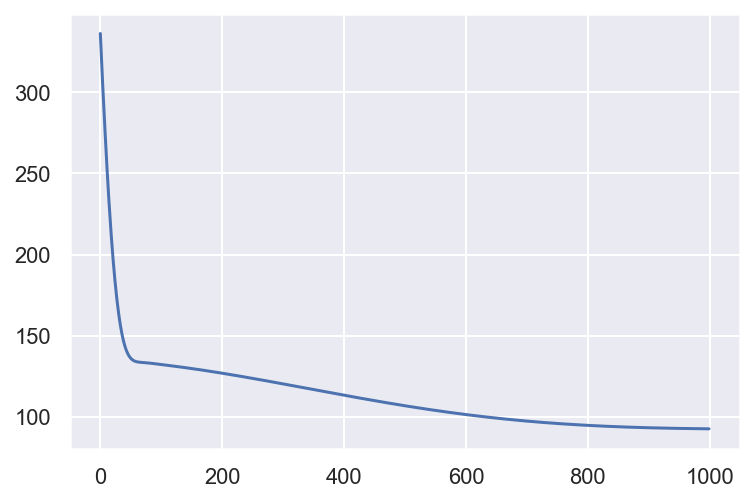

In [144]:
plt.plot(hist_loss);

In [145]:
class GPClassificationModel(ApproximateGP):

    def __init__(self, inducing_points, learn_inducing_locations):
        
        variational_distribution = CholeskyVariationalDistribution(
            num_inducing_points=inducing_points.size(0))
        
        variational_strategy = VariationalStrategy(
            self,
            inducing_points=inducing_points,
            variational_distribution=variational_distribution,
            learn_inducing_locations=learn_inducing_locations)
        
        super(GPClassificationModel, self).__init__(variational_strategy)
        
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        latent_pred = \
            gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
        return latent_pred


def safe_log(x): return torch.log(x + 1e-07)


def identity(x): return x


class DiscrepancyModel:

    def __init__(
            self,
            x: np.ndarray,
            y: np.ndarray,
            m: Callable,
            theta: Union[int, float, list],
            h: Union[str, Callable] = None,
            learn_inducing_locations: bool = False,
            jitter: Union[int, float] = 1e-07,
            n_samples: int = 40,
            n_inducing_points: int = 50,
            cholesky_max_tries: int = 1000):

        if h is None or h == "sigmoid" or h == torch.sigmoid:
            h = torch.sigmoid
            h_inv = torch.logit

        else:
            raise ValueError

        self.train_x = torch.from_numpy(x.astype(np.float32))
        self.train_y = torch.from_numpy(y.astype(np.float32))

        self.m = m
        self.theta = theta

        self.h = h
        self.h_inv = h_inv

        self.n_samples = n_samples

        self.n_x = self.train_x.size(0)
        self.n_y = self.train_y.size(0)

        self.jitter = jitter

        self.h_inv_m = self.h_inv(self.m(self.train_x, self.theta))
        
        inducing_delta = np.linspace(x[:, 0].min(), x[:, 0].max(), n_inducing_points)
        inducing_rep = np.linspace(x[:, 1].min(), x[:, 1].max(), n_inducing_points)
        
        inducing_points = np.concatenate((inducing_delta[None, :], inducing_rep[None, :]), axis=0).T
        inducing_points = torch.from_numpy(inducing_points.astype(np.float32))

        self.r_model = GPClassificationModel(
            inducing_points=inducing_points,
            learn_inducing_locations=learn_inducing_locations)

        self.cholesky_max_tries = cholesky_max_tries

        self.hist_loss = None

    def expected_log_prob(
            self, 
            observations: torch.Tensor, 
            function_dist: gpytorch.distributions.MultivariateNormal):

        L = psd_safe_cholesky(function_dist.covariance_matrix,
                              max_tries=self.cholesky_max_tries)

        gp_mean = function_dist.loc
        eta = torch.randn(self.n_x, self.n_samples)
        L_eta = L @ eta
        r = gp_mean + L_eta.T

        f = self.h(self.h_inv_m + r)
        log_prob = dist.Bernoulli(probs=f).log_prob(
            observations).mean(0)
        return log_prob

    def train(self, learning_rate=0.05, epochs=1000, seed=123,
              progress_bar=True):

        torch.random.manual_seed(seed)

        # Switch to 'train' mode
        self.r_model.train()

        # Use the adam optimizer
        optimizer = torch.optim.Adam(self.r_model.parameters(),
                                     lr=learning_rate)

        # Loss function
        mll = gpytorch.mlls.VariationalELBO(
            likelihood=self,  # Will call the 'expected_log_prob' method
            model=self.r_model,
            num_data=self.train_y.numel())

        self.hist_loss = []

        pbar = tqdm(total=epochs, leave=False) if progress_bar else None

        for i in range(epochs):
            # Zero backpropped gradients from previous iteration
            optimizer.zero_grad()
            # Get predictive output
            output = self.r_model(self.train_x)
            # Calc loss and backprop gradients
            loss = -mll(output, self.train_y)
            loss.backward()
            optimizer.step()

            self.hist_loss.append(loss.item())

            if pbar is not None:
                pbar.set_postfix(loss=loss.item())
                pbar.update()

        if pbar is not None:
            pbar.close()

        return self.hist_loss

    def pred(self, test_x, n_sample=1000):

        # Switch to 'eval' mode
        self.r_model.eval()

        r_pred = self.r_model(test_x).sample(torch.Size((n_sample,)))

        m_pred = self.m(test_x, self.theta)

        h_inv_m = self.h_inv(m_pred)

        f_pred = self.h(h_inv_m + r_pred)

        return m_pred, f_pred


In [152]:
theta = 0.05, 0.2

n_samples = 100
learn_inducing_locations = False
n_inducing_points = 100
epochs = 500
learning_rate=0.1

dm = DiscrepancyModel(
    x=x,
    y=y,
    m=m,
    theta=theta,
    n_samples=n_samples,
    learn_inducing_locations=learn_inducing_locations,
    n_inducing_points=n_inducing_points)

losses = dm.train(epochs=epochs, learning_rate=learning_rate)

  0%|          | 0/500 [00:00<?, ?it/s]

/Users/aureliennioche/.pyenv/versions/3.9.1/lib/python3.9/site-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/Users/aureliennioche/.pyenv/versions/3.9.1/lib/python3.9/site-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/Users/aureliennioche/.pyenv/versions/3.9.1/lib/python3.9/site-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/Users/aureliennioche/.pyenv/versions/3.9.1/lib/python3.9/site-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.

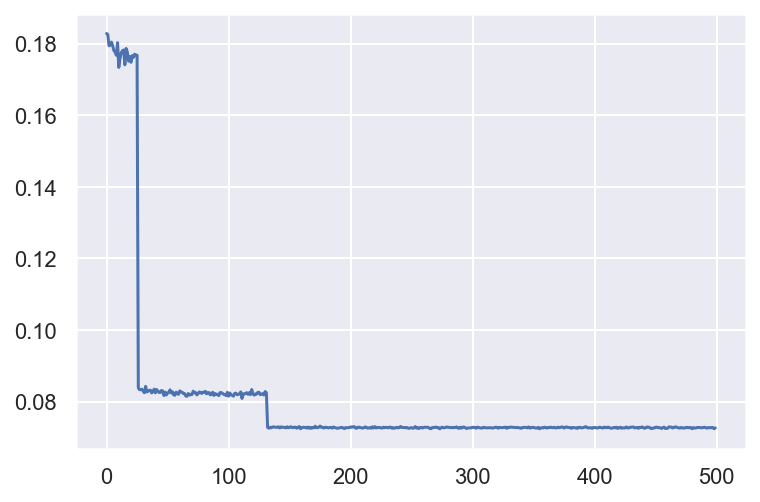

In [153]:
plt.plot(losses);

In [154]:
def plot_results(dm, fill_alpha=0.3, x_max=2**8, presentations=[64, 128, 192]):
    
    def create_input(x_plot, presentations):
        
        delta = x_plot.copy()
        rep = np.zeros(x_plot.shape)

        for pres in presentations:
            
            # Already assume presentation at 0
            if pres == 0:
                continue
            
            idx_after = x_plot >= pres
            delta[idx_after] = x_plot[idx_after] - pres
            rep[idx_after] += 1

        x_input = np.concatenate((delta[None, :], rep[None, :]), axis=0).T
        return torch.from_numpy(x_input.astype(np.float32))
    
    x_plot = np.linspace(0, x_max, 500)    
    test_x = create_input(x_plot, presentations)
    m_pred, f_pred = dm.pred(test_x)

    test_x = test_x.numpy()
    m_pred = m_pred.numpy()
    f_pred = f_pred.numpy()

    truth = m(test_x, theta)

    f_mean = f_pred.mean(axis=0)
    lower, upper = np.percentile(f_pred, [2.5, 97.5], axis=0)

    fig, ax = plt.subplots(figsize=(10, 6))

    # GP confidence
    h_conf = ax.fill_between(x_plot, upper, lower, color='C0', 
                             alpha=fill_alpha, label="Model + correction - Confidence")

    # GP mean
    h_mean, = ax.plot(x_plot, f_mean, label="Model + correction - Mean")

    # Model
    h_model, = ax.plot(x_plot, m_pred, color='C1', ls="--", label="Model alone")

    # Ground truth
    h_truth, = ax.plot(x_plot, truth, color='C2', ls="--", label="Ground truth")
    
    ax.set_xlabel("time")
    ax.set_ylabel("probability of recall")
    return ax

/Users/aureliennioche/.pyenv/versions/3.9.1/lib/python3.9/site-packages/gpytorch/lazy/lazy_tensor.py:1632: NumericalWarning: Runtime Error when computing Cholesky decomposition: Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.. Using symeig method.
  warnings.warn(


<AxesSubplot:xlabel='time', ylabel='probability of recall'>

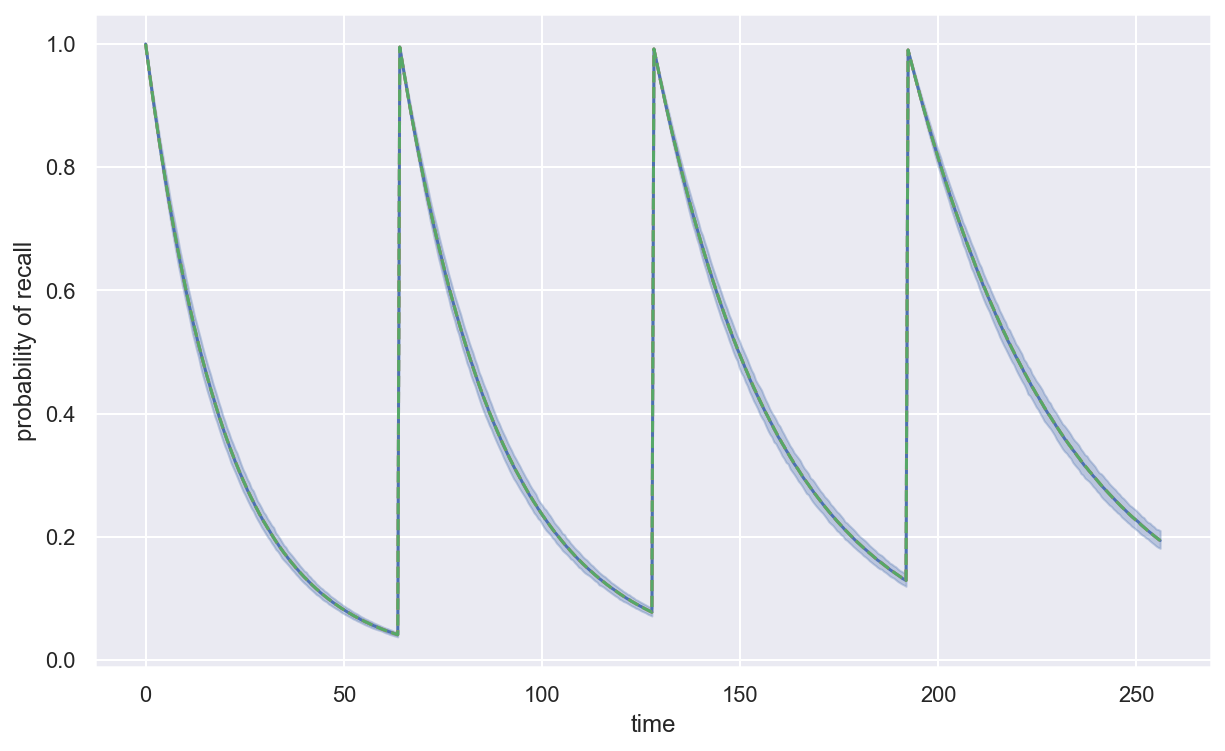

In [155]:
plot_results(dm, x_max=2**8, presentations=[64, 128, 192])

In [156]:
df_all_users = get_data("data/data_character_meaning.csv")

number of user 53
number of items 1998
total number of observations (excluding first presentation) 70618
minimum number of observation for a single user 1285
maximum number of observation for a single user 1404


In [157]:
user = 3
df = df_all_users[df_all_users.u == user]
print(f"n observations for user {user}: {len(df)}")

n observations for user 3: 1294


In [158]:
x = np.concatenate((df.d.values[None, :], df.r.values[None, :]), axis=0).T
y = df.y.values

In [159]:
hist_loss, (alpha, beta) = fit_data(x, y, epochs=5000, learning_rate=0.1)

  0%|          | 0/5000 [00:00<?, ?it/s]

{'unc_alpha': tensor([-10.4524]), 'unc_beta': tensor([-1.8679])}
alpha 2.8878457669634372e-05
beta 0.13378801941871643


In [160]:
def obj(theta):
    p_suc = m(x, theta)
    p = p_suc**y*(1-p_suc)**(1-y)
    logp = np.log(p+1e-07)
    return - logp.sum()

scipy.optimize.minimize(obj, x0=(0, 0.5), bounds=((0, np.inf), (0, 1)))

      fun: 1580.6993998006467
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([1.12515993e+03, 1.88038030e-01])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 159
      nit: 31
     njev: 53
   status: 0
  success: True
        x: array([2.93472319e-05, 1.36750821e-01])

In [162]:
theta = (alpha, beta)

n_samples = 100
learn_inducing_locations = False
n_inducing_points = 100
epochs = 500
learning_rate=0.05

dm = DiscrepancyModel(
    x=x,
    y=y,
    m=m,
    theta=theta,
    n_samples=n_samples,
    learn_inducing_locations=learn_inducing_locations,
    n_inducing_points=n_inducing_points)

losses = dm.train(epochs=epochs, learning_rate=learning_rate)

  0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
plt.plot(losses);

In [ ]:
plot_results(dm, x_max=1e5*4, presentations=[1e5*i for i in range(4)])